In [5]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.scalar_mediator import ScalarMediator

In [6]:
gsxx = 1.0
gsff = 1.0
gsGG = 1.0
gsFF = 1.0
ms = 1.0
mx = 144.

vx_mw = 1.0e-3 # DM velocity in Milky Way halo
def ex(mx, vx=vx_mw):
    return mx + 0.5 * mx * vx**2

### Effective area comparison

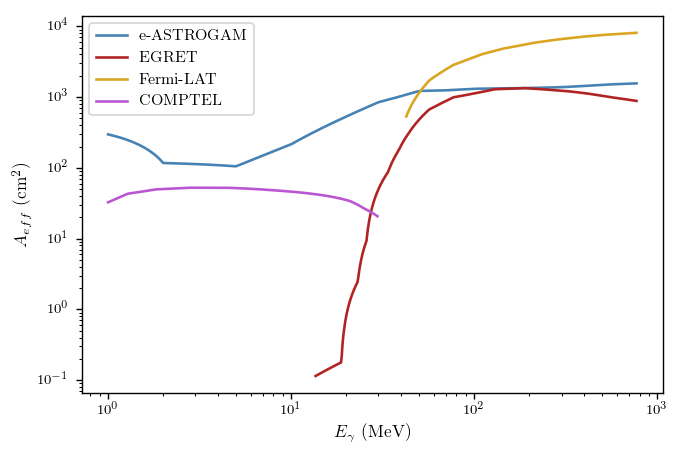

In [3]:
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import A_eff_e_astrogam, A_eff_comptel, A_eff_egret, A_eff_fermi_lat

e_gams = np.logspace(0, np.log10(770), 770)

plt.figure(figsize=(6, 4))

plt.loglog(e_gams, [A_eff_e_astrogam(e) for e in e_gams], label="e-ASTROGAM")
plt.loglog(e_gams, [A_eff_egret(e) for e in e_gams], label="EGRET")
plt.loglog(e_gams, [A_eff_fermi_lat(e) for e in e_gams], label="Fermi-LAT")
plt.loglog(e_gams, [A_eff_comptel(e) for e in e_gams], label="COMPTEL")

plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$A_{\text{eff}}$ (cm$^2$)")
plt.legend()

### DM annihilation spectra

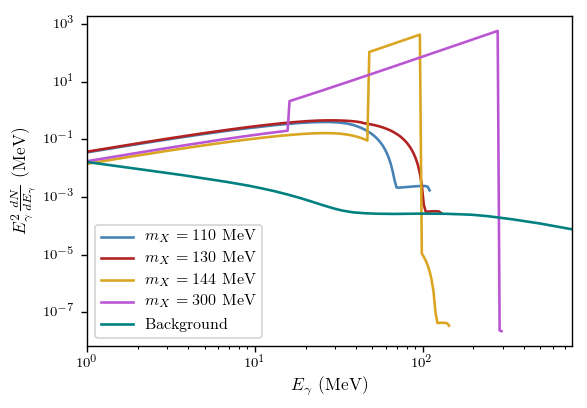

In [9]:
from hazma.gamma_ray_limits import gamma_ray_limit_parameters

sm = ScalarMediator(mx, ms, gsxx, gsff, gsGG, gsFF)

e_gams = np.logspace(0, np.log10(770), 250)

# DM spectra
for mx in [110., 130., 144., 300.]:
    sm.mx = mx
    spectra = sm.spectra(e_gams, 2. * ex(mx))
    plt.loglog(e_gams, e_gams**2 * spectra["total"], label=r"$m_X = %.0f$ MeV" % mx)

# Background spectrum
plt.loglog(gamma_ray_limit_parameters.e_Bs, gamma_ray_limit_parameters.e_Bs * gamma_ray_limit_parameters.dPhi_dEdOmega_Bs, label="Background")

plt.xlim(e_gams[[0, -1]])
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$E_\gamma^2 \frac{dN}{dE_\gamma}$ (MeV)")
plt.legend()

In [10]:
np.sum(spectra["total"][1:] * e_gams[1:] * (e_gams[1:] - e_gams[:-1]))

294.27283983684

### Compute limits

In [6]:
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import A_eff_comptel, A_eff_egret, A_eff_e_astrogam, A_eff_fermi_lat, T_obs_comptel, T_obs_e_astrogam, T_obs_egret, T_obs_fermi_lat

In [5]:
sm = ScalarMediator(mx, ms, gsxx, gsff, gsGG, gsFF)

mx_min = 50.
mx_max = 1000.
n_mxs = 25

mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)

In [7]:
# Compute limits
sv_lims_egret = sm.compute_limits(mxs, A_eff=A_eff_egret, T_obs=T_obs_egret)
sv_lims_comptel = sm.compute_limits(mxs, A_eff=A_eff_comptel, T_obs=T_obs_comptel)
sv_lims_fermi_lat = sm.compute_limits(mxs, A_eff=A_eff_fermi_lat, T_obs=T_obs_fermi_lat)
sv_lims_e_astrogam = sm.compute_limits(mxs, A_eff=A_eff_e_astrogam, T_obs=T_obs_e_astrogam)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13

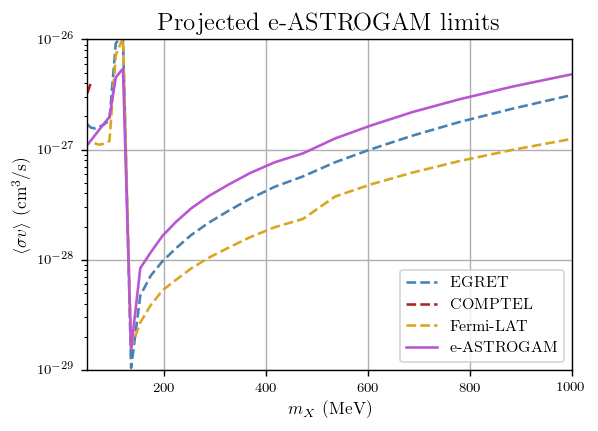

In [8]:
plt.plot(mxs, sv_lims_egret, '--', label="EGRET")
plt.plot(mxs, sv_lims_comptel, '--', label="COMPTEL")
plt.plot(mxs, sv_lims_fermi_lat, '--', label="Fermi-LAT")
plt.plot(mxs, sv_lims_e_astrogam, label="e-ASTROGAM")

plt.grid()
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-29, 1e-26])
plt.yscale("log")
plt.xlabel(r"$m_X$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Projected e-ASTROGAM limits")
plt.legend()

### Scratch

In [41]:
from scipy.interpolate import interp1d
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import eASTROGAM_params, dSph_params
from hazma.gamma_ray_limits.compute_limits import __f_lim, __jac_lim

sm = ScalarMediator(104., ms, gsxx, gsff, gsGG, gsFF)

e_gams = np.logspace(np.log10(sm.mx / 100.), np.log10(sm.mx), 200)                 
dN_dE_DM = interp1d(e_gams, sm.spectra(e_gams, 2.001*sm.mx)["total"])

def fn(e_a, e_b):
    e_a = min([e_a, e_b])
    e_b = max([e_a, e_b])
    
    if e_a == e_b:
        return 0.
    else:
        return __f_lim([e_a, e_b], dN_dE_DM, eASTROGAM_params, dSph_params)

In [36]:
def npmap2d(fun, x_spec, y_spec, doPrint=False):
    xs = np.linspace(*x_spec)
    ys = np.linspace(*y_spec)
    Z = np.empty(len(xs) * len(ys))
    i = 0
    for y in ys:
        for x in xs:
            Z[i] = fun(x, y)
            if doPrint: print([i, x, y, Z[i]])
            i += 1
    X, Y = np.meshgrid(xs, ys)
    Z.shape = X.shape
    return X, Y, Z

In [42]:
e_as, e_bs, fn_vals = npmap2d(fn, (sm.mx / 50., sm.mx, 10), (sm.mx / 50., sm.mx, 10))

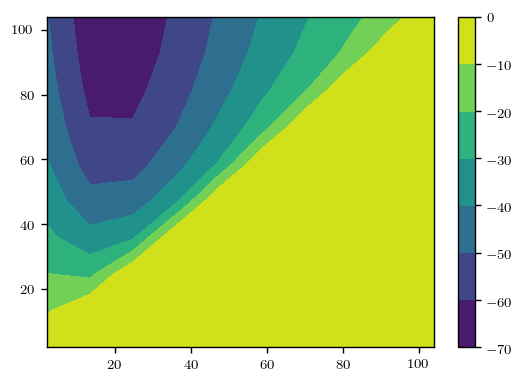

In [43]:
CS = plt.contourf(e_as, e_bs, fn_vals)
plt.colorbar()  
plt.show()

In [46]:
import scipy
from scipy import optimize
from hazma.parameters import neutral_pion_mass as mpi0

def f(e_ab):
    e_a = min(e_ab)
    e_b = max(e_ab)
    
    if e_a == e_b:
        return 0.
    else:
        return __f_lim([e_a, e_b], dN_dE_DM, eASTROGAM_params, dSph_params)

e_a_0 = 0.5 * (sm.mx - sm.mx / 100.)
e_b_0 = 0.75 * (sm.mx - sm.mx / 100.)
e_bounds = [sm.mx / 100., sm.mx]

limit_obj = scipy.optimize.minimize(f, [e_a_0, e_b_0],
                                    bounds=[e_bounds, e_bounds],
#                                     args=(dN_dE_DM, eASTROGAM_params,
#                                           dSph_params),
                                    method="L-BFGS-B",
                                    options={"ftol": 1e-3})

In [47]:
limit_obj

      fun: -67.95842881550962
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00388809, 0.03462048])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 5
   status: 0
  success: True
        x: array([ 18.57464769, 104.        ])